In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed_all(seed)  # For all GPUs
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python random
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
seed = 42
set_seed(seed)

# Mean and standard deviation for normalization (CIFAR-10 specific)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.6),   # Horizontal flip with probability 0.5
    transforms.RandomCrop(32, padding=4),     # Random crop with padding of 4 pixels
    transforms.RandomRotation(15),           # Random rotation of ±15 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Uncomment if needed
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Transformations for the validation and test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Load CIFAR-10 training dataset both augmented and not augmented
dataset_augmented = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
dataset_normal = CIFAR10(root='./data', train=True, download=True, transform=test_transforms)

# Step 3: Suddividere il dataset in Train (80%) e Validation (20%)
train_size = int(0.8 * len(dataset_augmented))  # 80% dei dati
val_size = len(dataset_augmented) - train_size  # 20% dei dati
train_dataset, val_dataset = random_split(dataset_augmented, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
# take validation indices for not augmented dataset
val_dataset = Subset(dataset_normal, val_dataset.indices)
# Load CIFAR-10 dataset for testing
test_dataset = CIFAR10(
    root='./data', train=False, transform=test_transforms, download=True
)
# DataLoader for the training set
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
# DataLoader for the validation set
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=2
)
# DataLoader for the test set
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)
# Output the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Val set size: 10000
Test set size: 10000


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Normalization added
# Dropout to be set  
drop_rate= None
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)  # first dropout added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # dropout after Relu
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.layer_norm = nn.LayerNorm(512) #normalization added
        self.fc = nn.Sequential(
        nn.Dropout(p=drop_rate),  # second dropout before fc
        nn.Linear(512, num_classes)
        )

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, out_channels, stride))
        self.in_planes = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.layer_norm(x)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

#### Define the class fot the RFF transformations

In [5]:
class RandomFourierFeatures(nn.Module):
    def __init__(self, input_dim, D=None, gamma=1.0):
        super(RandomFourierFeatures, self).__init__()
        self.input_dim = input_dim
        self.D = D if D is not None else input_dim  # Numero di RFF (default uguale a input_dim)
        self.gamma = gamma
        
        # Calcolare la deviazione standard in base a gamma
        std_dev = np.sqrt(2 * self.gamma)
        
        # Campionamento dei pesi w da N(0, 2*gamma)
        self.register_buffer("weights", torch.normal(0, std_dev, size=(self.D, self.input_dim)))
        
        # Campionamento del bias da U[0, 2pi]
        self.register_buffer("bias", 2 * np.pi * torch.rand(self.D))
        
        # Precalcolo del fattore di scala
        self.register_buffer("scale", torch.sqrt(torch.tensor(2.0 / self.D)))

    def forward(self, x):
        # Proiezione lineare e applicazione del coseno
        projections = torch.matmul(x, self.weights.T) + self.bias
        return self.scale * torch.cos(projections)



In [6]:
# Custom loss function with Square Hinge Loss + L2 Regularization
def square_hinge_loss(outputs, targets, weights, C):
    
    # Create a one-hot tensor for the targets (true classes)
    targets_one_hot = torch.full_like(outputs, -1, device=outputs.device)  # All classes initially set to -1
    targets_one_hot[torch.arange(len(targets)), targets] = 1  # Set the correct class to +1
    
    # Calculate the margin
    margins = 1 - targets_one_hot * outputs  # shape: (n_samples, n_classes)
    # Square hinge loss: max(0, margin)^2
    hinge_loss = torch.clamp(margins, min=0) ** 2  # shape: (n_samples, n_classes)
    
    # Average over all samples and classes
    hinge_loss = hinge_loss.mean()

    # Calculate L2 regularization (mean of squared weights)
    reg_loss = torch.mean(torch.square(weights))
    # Total loss with the regularization parameter C
    total_loss = C * hinge_loss + reg_loss
    
    return total_loss


# Set global parameters

In [7]:
drop_rate = 0.2
embedding_dim = 512
rff_dim = 2048

# C=0.1, $\gamma$ = 1

In [8]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=1),   
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_01_1.pth")

Epoch 1/50:
Train Loss: 0.0795, Train Acc: 10.05%
Val Loss: 0.0628, Val Acc: 9.99%
Epoch 2/50:
Train Loss: 0.0527, Train Acc: 10.07%
Val Loss: 0.0451, Val Acc: 10.16%
Epoch 3/50:
Train Loss: 0.0411, Train Acc: 9.89%
Val Loss: 0.0384, Val Acc: 10.09%
Epoch 4/50:
Train Loss: 0.0372, Train Acc: 10.03%
Val Loss: 0.0365, Val Acc: 10.58%
Epoch 5/50:
Train Loss: 0.0363, Train Acc: 10.16%
Val Loss: 0.0362, Val Acc: 10.09%
Epoch 6/50:
Train Loss: 0.0361, Train Acc: 10.33%
Val Loss: 0.0361, Val Acc: 11.15%
Epoch 7/50:
Train Loss: 0.0361, Train Acc: 9.88%
Val Loss: 0.0361, Val Acc: 11.94%
Epoch 8/50:
Train Loss: 0.0361, Train Acc: 10.21%
Val Loss: 0.0361, Val Acc: 10.44%
Epoch 9/50:
Train Loss: 0.0361, Train Acc: 10.89%
Val Loss: 0.0361, Val Acc: 11.75%
Epoch 10/50:
Train Loss: 0.0361, Train Acc: 11.28%
Val Loss: 0.0360, Val Acc: 13.02%
Epoch 11/50:
Train Loss: 0.0356, Train Acc: 15.72%
Val Loss: 0.0353, Val Acc: 17.49%
Epoch 12/50:
Train Loss: 0.0349, Train Acc: 19.32%
Val Loss: 0.0346, Val Acc:

In [9]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0148, Test Accuracy: 75.42%


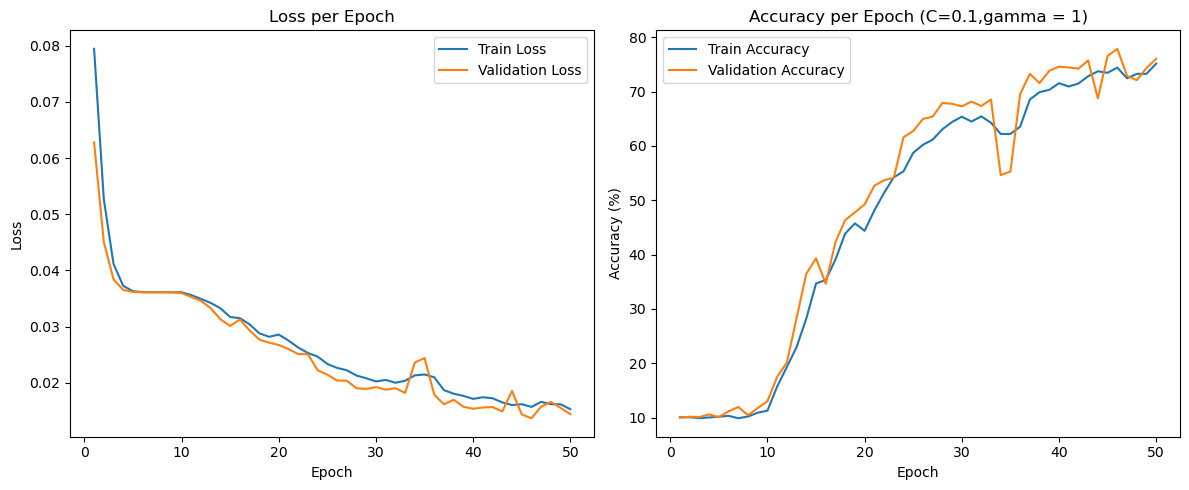

In [10]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=0.1,gamma = 1)")
plt.legend()

plt.tight_layout()
plt.show()

# C=1, $\gamma$ = 1

In [11]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=1), 
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_1_1.pth")

Epoch 1/50:
Train Loss: 0.7239, Train Acc: 10.59%
Val Loss: 0.5011, Val Acc: 12.19%
Epoch 2/50:
Train Loss: 0.3992, Train Acc: 13.94%
Val Loss: 0.3907, Val Acc: 18.13%
Epoch 3/50:
Train Loss: 0.3666, Train Acc: 20.29%
Val Loss: 0.3963, Val Acc: 19.88%
Epoch 4/50:
Train Loss: 0.3537, Train Acc: 23.95%
Val Loss: 0.3542, Val Acc: 26.77%
Epoch 5/50:
Train Loss: 0.3344, Train Acc: 30.69%
Val Loss: 0.3197, Val Acc: 34.58%
Epoch 6/50:
Train Loss: 0.3215, Train Acc: 33.87%
Val Loss: 0.2970, Val Acc: 40.97%
Epoch 7/50:
Train Loss: 0.3103, Train Acc: 36.75%
Val Loss: 0.2931, Val Acc: 41.52%
Epoch 8/50:
Train Loss: 0.3003, Train Acc: 39.68%
Val Loss: 0.2785, Val Acc: 44.94%
Epoch 9/50:
Train Loss: 0.2915, Train Acc: 41.82%
Val Loss: 0.2752, Val Acc: 46.49%
Epoch 10/50:
Train Loss: 0.2876, Train Acc: 42.65%
Val Loss: 0.2742, Val Acc: 46.41%
Epoch 11/50:
Train Loss: 0.2783, Train Acc: 45.48%
Val Loss: 0.2643, Val Acc: 48.75%
Epoch 12/50:
Train Loss: 0.2706, Train Acc: 47.00%
Val Loss: 0.2503, Val A

In [12]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.1288, Test Accuracy: 77.61%


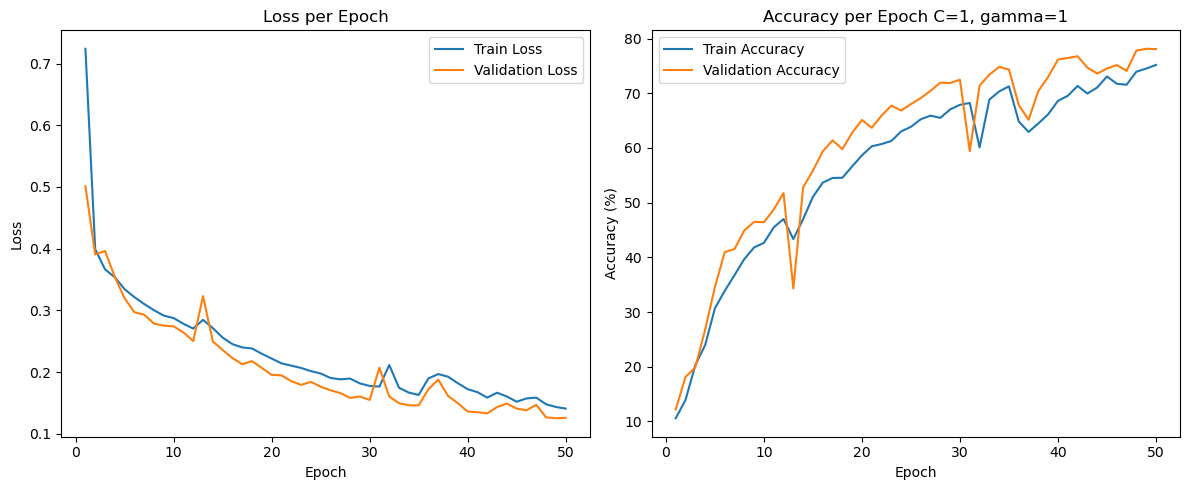

In [15]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch C=1, gamma=1")
plt.legend()

plt.tight_layout()
plt.show()

# C=10, $\gamma$ = 1

In [16]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=1),  
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_10_1.pth")

Epoch 1/50:
Train Loss: 7.9276, Train Acc: 10.20%
Val Loss: 6.2551, Val Acc: 9.07%
Epoch 2/50:
Train Loss: 4.7236, Train Acc: 12.43%
Val Loss: 3.7512, Val Acc: 16.03%
Epoch 3/50:
Train Loss: 3.6947, Train Acc: 18.93%
Val Loss: 3.5104, Val Acc: 23.85%
Epoch 4/50:
Train Loss: 3.4057, Train Acc: 27.25%
Val Loss: 3.2802, Val Acc: 31.65%
Epoch 5/50:
Train Loss: 3.1921, Train Acc: 33.38%
Val Loss: 3.0942, Val Acc: 36.87%
Epoch 6/50:
Train Loss: 3.0033, Train Acc: 39.20%
Val Loss: 2.8369, Val Acc: 43.36%
Epoch 7/50:
Train Loss: 2.8748, Train Acc: 42.62%
Val Loss: 2.7975, Val Acc: 44.63%
Epoch 8/50:
Train Loss: 2.7303, Train Acc: 46.45%
Val Loss: 2.4522, Val Acc: 52.88%
Epoch 9/50:
Train Loss: 2.5755, Train Acc: 50.67%
Val Loss: 2.4041, Val Acc: 54.48%
Epoch 10/50:
Train Loss: 2.4643, Train Acc: 53.32%
Val Loss: 2.3415, Val Acc: 56.29%
Epoch 11/50:
Train Loss: 2.4460, Train Acc: 53.01%
Val Loss: 2.5635, Val Acc: 48.01%
Epoch 12/50:
Train Loss: 2.7134, Train Acc: 45.88%
Val Loss: 2.8628, Val Ac

In [17]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.4079, Test Accuracy: 74.99%


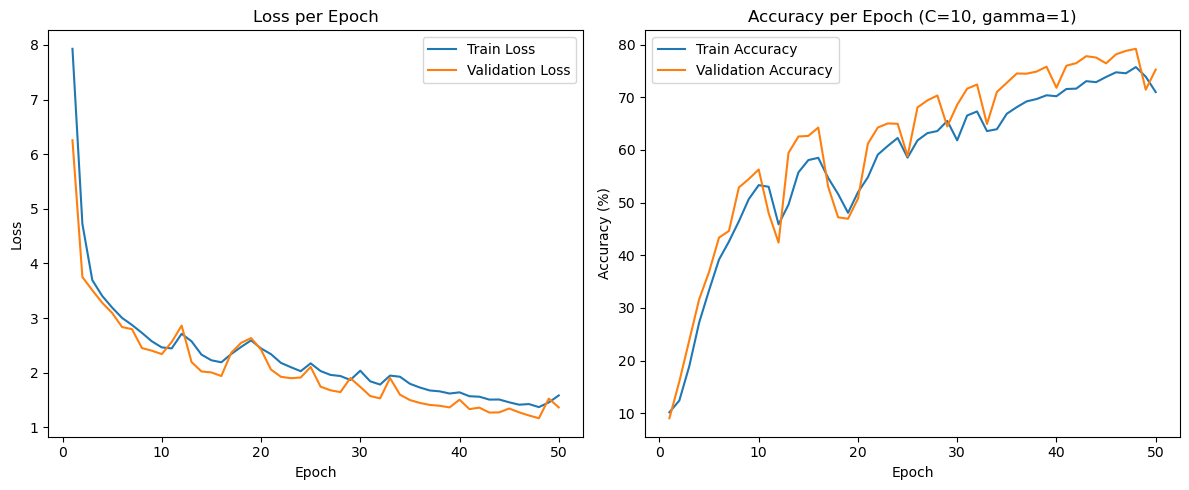

In [18]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=10, gamma=1)")
plt.legend()

plt.tight_layout()
plt.show()

# C=100, $\gamma$ = 1

In [19]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=1), 
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_100_1.pth")

Epoch 1/50:
Train Loss: 79.2965, Train Acc: 9.80%
Val Loss: 62.6967, Val Acc: 9.46%
Epoch 2/50:
Train Loss: 44.1377, Train Acc: 12.86%
Val Loss: 35.8398, Val Acc: 19.00%
Epoch 3/50:
Train Loss: 36.1784, Train Acc: 21.45%
Val Loss: 37.0438, Val Acc: 18.82%
Epoch 4/50:
Train Loss: 36.8178, Train Acc: 18.62%
Val Loss: 35.1059, Val Acc: 22.10%
Epoch 5/50:
Train Loss: 34.3815, Train Acc: 24.12%
Val Loss: 31.8970, Val Acc: 31.97%
Epoch 6/50:
Train Loss: 32.1836, Train Acc: 30.93%
Val Loss: 30.5191, Val Acc: 36.07%
Epoch 7/50:
Train Loss: 32.6544, Train Acc: 29.80%
Val Loss: 33.6298, Val Acc: 26.39%
Epoch 8/50:
Train Loss: 32.1186, Train Acc: 30.95%
Val Loss: 31.7156, Val Acc: 32.64%
Epoch 9/50:
Train Loss: 31.0156, Train Acc: 34.55%
Val Loss: 28.8683, Val Acc: 42.46%
Epoch 10/50:
Train Loss: 29.6711, Train Acc: 39.22%
Val Loss: 27.5791, Val Acc: 45.29%
Epoch 11/50:
Train Loss: 29.1576, Train Acc: 39.73%
Val Loss: 28.1055, Val Acc: 43.64%
Epoch 12/50:
Train Loss: 28.3794, Train Acc: 42.41%
Va

In [20]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 12.5892, Test Accuracy: 78.15%


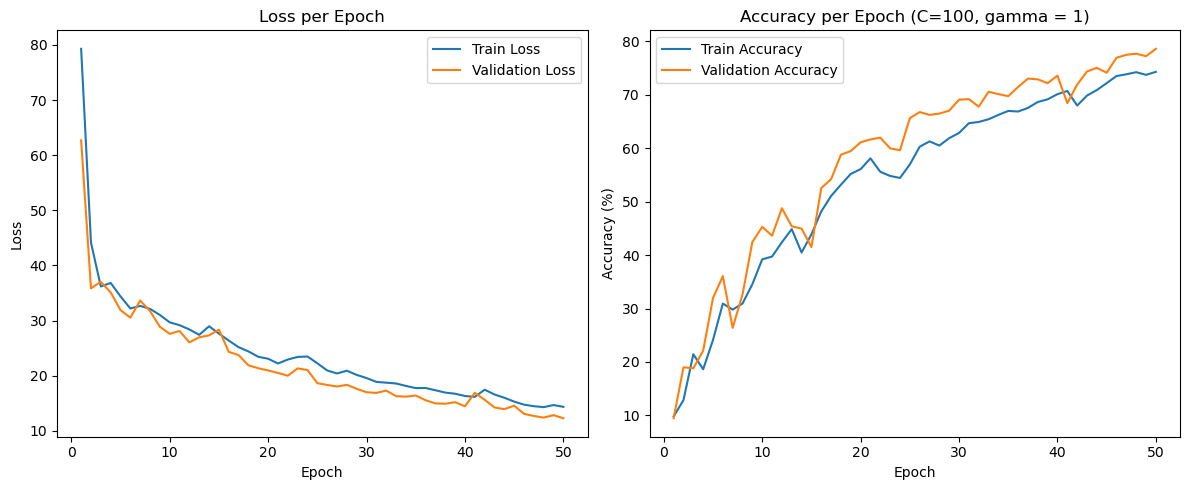

In [21]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=100, gamma = 1)")
plt.legend()

plt.tight_layout()
plt.show()

# C=1000, $\gamma$ = 1

In [22]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=1), 
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 1000)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 1000)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_1000_1.pth")

Epoch 1/50:
Train Loss: 794.7069, Train Acc: 10.34%
Val Loss: 525.2957, Val Acc: 11.59%
Epoch 2/50:
Train Loss: 404.7008, Train Acc: 15.30%
Val Loss: 363.5089, Val Acc: 18.64%
Epoch 3/50:
Train Loss: 356.0273, Train Acc: 24.15%
Val Loss: 343.4023, Val Acc: 28.20%
Epoch 4/50:
Train Loss: 337.4098, Train Acc: 29.18%
Val Loss: 322.0284, Val Acc: 34.03%
Epoch 5/50:
Train Loss: 330.4374, Train Acc: 31.46%
Val Loss: 371.1472, Val Acc: 22.28%
Epoch 6/50:
Train Loss: 331.4914, Train Acc: 30.20%
Val Loss: 308.0115, Val Acc: 36.77%
Epoch 7/50:
Train Loss: 316.1579, Train Acc: 34.23%
Val Loss: 325.4183, Val Acc: 33.71%
Epoch 8/50:
Train Loss: 338.3961, Train Acc: 27.11%
Val Loss: 319.2317, Val Acc: 33.20%
Epoch 9/50:
Train Loss: 315.6735, Train Acc: 33.33%
Val Loss: 319.6545, Val Acc: 31.92%
Epoch 10/50:
Train Loss: 308.4091, Train Acc: 34.65%
Val Loss: 300.0047, Val Acc: 37.97%
Epoch 11/50:
Train Loss: 306.9455, Train Acc: 35.65%
Val Loss: 309.0658, Val Acc: 33.53%
Epoch 12/50:
Train Loss: 296.9

In [23]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 179.6430, Test Accuracy: 67.12%


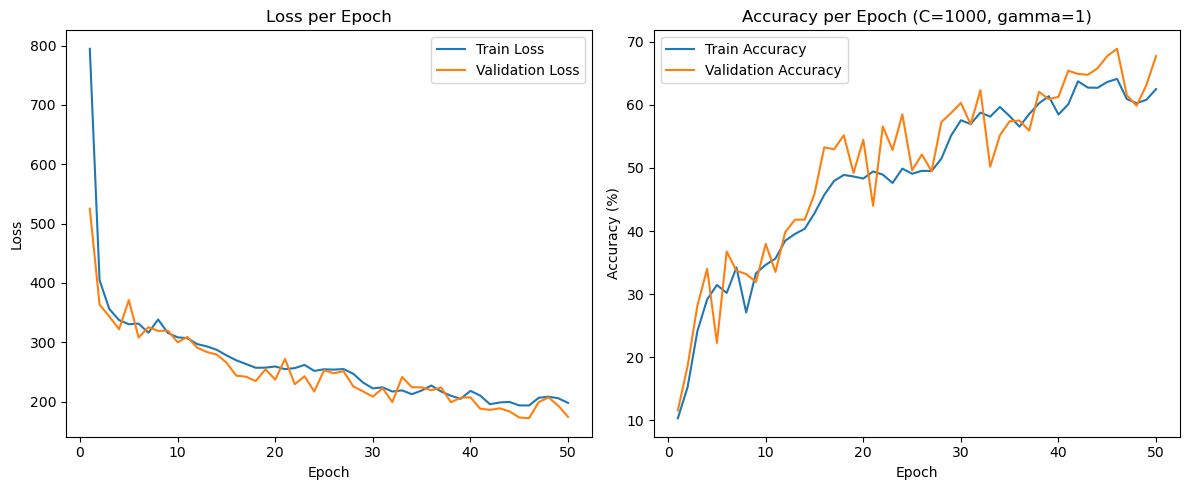

In [24]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=1000, gamma=1)")
plt.legend()

plt.tight_layout()
plt.show()